## **Aggregated Residual Transformations for Deep Neural Networks**

Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated residual transformations for deep neural networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1492-1500).

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [7]:
def Conv2D_BN_ReLU(
    x, 
    filters, 
    kernel_size, 
    strides = 1,
    padding = "same",
    groups = 1,
    use_activation = True
):
    ## Implemented as grouped convolutions.
    x = tf.keras.layers.Conv2D(
        filters, 
        kernel_size, 
        strides = strides, 
        padding = padding, 
        groups = groups)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if use_activation:
        x = tf.keras.layers.Activation("relu")(x)

    return x


def residual_block(
    x, 
    output_filters, 
):
    assert x.shape[-1] <= output_filters, \
        "The size of the output dimension must be equal to or greater than the size of the input dimension."

    residual = x

    strides = 2 if (residual.shape[-1] < output_filters and output_filters !=  256) else 1

    ## Compared to ResNet, the I/O dimension of conv also needs to be modified.
    x = Conv2D_BN_ReLU(x, output_filters // 2, 1, strides = strides)
    x = Conv2D_BN_ReLU(x, output_filters // 2, 3, groups = 32)
    x = Conv2D_BN_ReLU(x, output_filters, 1, use_activation = False)

    ## When the input and output are the same dimensions, the shortcut performs identity mapping.
    ## When the demensions increase, the projection shortcut in Eqn.(2) is used to match dimensions (done by 1x1 convolutions).
    if residual.shape[-1] < output_filters:
        residual = Conv2D_BN_ReLU(residual, output_filters, 1, strides = strides, use_activation = False)

    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.Activation("relu")(x)

    return x

In [16]:
IMAGE_SIZE = [224, 224, 3] ## Cropped ImageNet test size.

def ResNeXt_101(
    model_name
):
    """Base ResNet50"""
    model_input = tf.keras.layers.Input(shape = IMAGE_SIZE, dtype = tf.float32)

    ## Entry flow.
    x = Conv2D_BN_ReLU(model_input, 64, 7, strides = 2, groups = 1)
    x = tf.keras.layers.MaxPool2D(3, strides = 2, padding = "same")(x)

    ## Middle flow.
    for output_filters in [256] * 3 + [512] * 4 + [1024] * 23 + [2048] * 3:
        x = residual_block(x, output_filters)

    ## Exit flow.
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model_output = tf.keras.layers.Dense(1000, activation = "softmax")(x)

    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [17]:
tmp = ResNeXt_101("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_414 (Conv2D)             (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_413 (BatchN (None, 112, 112, 64) 256         conv2d_414[0][0]                 
__________________________________________________________________________________________________
activation_397 (Activation)     (None, 112, 112, 64) 0           batch_normalization_413[0][0]    
________________________________________________________________________________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.879486 to fit



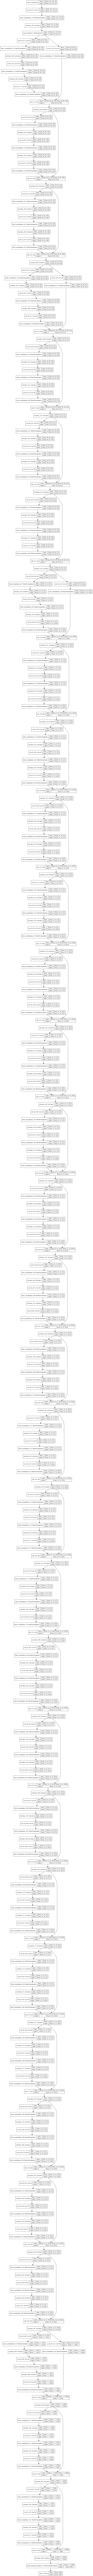

In [18]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [19]:
del tmp